# Multiple ML Classifiers

Names: Christian Juarez, Analiese Gonzalez, Alyssa Amancio

This notebook implements four or more different ML classifiers for the planet-host prediction problem using the preprocessed Kepler features.

- Target: `label_lenient` (planet-host vs non-host)
- Features: all engineered columns from `table_v1.parquet`
- Split: pre-defined `train/val/test` from `split_v1.csv`

Note:This submission focuses only on implementing and fitting the models. Full evaluation, model comparison, and hyperparameter tuning will be done in the next assignment.

In [51]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Adjust ROOT. When this notebook lives in notebooks/
# the data folder is at ../data/processed/..
ROOT = Path("/Users/chrisjuarez/CPSC483_ML_Project") 

X_full = pd.read_parquet(ROOT / 'data/processed/features/table_v1.parquet')
y_full = pd.read_csv(ROOT / 'data/processed/labels/labels_v1.csv')
splits = pd.read_csv(ROOT / 'data/processed/splits/split_v1.csv')

# Merge into a single DataFrame
df = X_full.merge(y_full, on='kepid').merge(splits, on='kepid')
df.head()

,kepid,teff,logg,feh,radius,mass,kepmag,rrmscdpp03p0,rrmscdpp06p0,rrmscdpp12p0,...,detection_eff,rrmscdpp03p0_log,rrmscdpp06p0_log,rrmscdpp12p0_log,nconfp,nkoi,ntce,label_strict,label_lenient,split
0,10000785,5333.0,4.616,-1.00,0.650,0.635,15.749,445.410,499.980,589.300,...,0.000054,6.101238,6.216566,6.380631,0,0,2,0,0,train
1,10000797,6289.0,4.270,-0.44,1.195,0.968,13.994,80.767,60.264,45.939,...,0.001693,4.403874,4.115192,3.848849,0,0,0,0,0,train
2,10000800,5692.0,4.547,-0.04,0.866,0.965,15.379,226.348,184.595,158.220,...,0.000264,5.426482,5.223567,5.070287,0,0,0,0,0,test
3,10000823,6580.0,4.377,-0.16,1.169,1.191,15.558,181.468,148.879,132.140,...,0.000590,5.206575,5.009828,4.891401,0,0,0,0,0,val
4,10000827,5648.0,4.559,-0.10,0.841,0.939,14.841,124.834,92.096,67.532,...,0.000517,4.834964,4.533631,4.227301,0,0,0,0,0,train


## Train / Val / Test Split

We use the existing `split` column to create train, validation, and test sets. The prediction target is `label_lenient` (binary classification).

In [52]:
# Target column (binary classification)
target_col = 'label_lenient'

# Features: drop non-feature columns
non_feature_cols = ['split', 'label_lenient', 'label_strict'] # add any other features to reduce if needed 
feature_cols = [c for c in df.columns if c not in non_feature_cols]

X = df[feature_cols].copy()
y = df[target_col].copy()

X_train = X[df['split'] == 'train']
y_train = y[df['split'] == 'train']

X_val = X[df['split'] == 'val']
y_val = y[df['split'] == 'val']

X_test = X[df['split'] == 'test']
y_test = y[df['split'] == 'test']

X_train.shape, X_val.shape, X_test.shape

((105532, 27), (15077, 27), (30153, 27))

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


### 1. Logistic Regression (with Standardization)

A linear classification model that estimates the probability of a star being a planet host. We use an L2-penalized logistic regression with standardized inputs.

In [54]:
# Logistic Regression Model
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight="balanced",
        solver="lbfgs"
    ))
])
print("\nTraining Logistic Regression...")
log_reg.fit(X_train, y_train)
print("Logistic Regression trained.\n")


Training Logistic Regression...
Logistic Regression trained.



### 2. Random Forest Classifier

An ensemble of decision trees trained with bootstrap aggregation (bagging). This is similar to the model already used in the earlier notebook, but we keep it here as one of the required ML techniques.

In [87]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=10,
    class_weight='balanced',  # ← Add this
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
print('Random Forest model fitted.')

Random Forest model fitted.


### 3. Gradient Boosting Classifier

A boosting-based ensemble that builds trees sequentially, where each new tree tries to correct the errors of the previous ensemble. This often performs well on tabular data with structured features.

In [97]:
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,          
    max_depth=5,               
    min_samples_split=10,    
    min_samples_leaf=4,         
    subsample=0.8,              
    random_state=42
)

# Manual class weighting for GB
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)
gb_clf.fit(X_train, y_train, sample_weight=sample_weights)
print('Gradient Boosting model fitted.')

Gradient Boosting model fitted.


### 4. K-Nearest Neighbors (KNN) Classifier

A simple instance-based learner that classifies each sample based on the majority label among its `k` nearest neighbors in feature space (after scaling).

In [112]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

knn_clf = ImbPipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(
        n_neighbors=25,          
        weights='distance',    
        metric='minkowski',     
        p=2
    ))
])
knn_clf.fit(X_train, y_train)
print('KNN model fitted.')

KNN model fitted.


In [99]:
from sklearn.neural_network import MLPClassifier

# Neural Network (MLP) Model
mlp_nn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128,64),  # two dense hidden layers with 128 and 64 neurons
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        alpha=0.001,
        max_iter=100,               # keep training quick
        random_state=42,
        verbose=False
    ))
])

print("Training Neural Network (MLP)...")
mlp_nn.fit(X_train, y_train)
print("Neural Network trained.\n")     

Training Neural Network (MLP)...
Neural Network trained.



# Evaluation Metrics and Analysis Below 

In [59]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    matthews_corrcoef,
    average_precision_score,
    log_loss,
)

In [100]:
def evaluate_model(name, clf,
                   X_train, y_train,
                   X_val,   y_val,
                   X_test,  y_test):
    print(f"\n== {name} ==")

    splits = {
        "Train": (X_train, y_train),
        "Val":   (X_val,   y_val),
        "Test":  (X_test,  y_test),
    }

    split_metrics = {}

    for split_name, (X_split, y_split) in splits.items():
        y_pred = clf.predict(X_split)

        # basic metrics
        acc      = accuracy_score(y_split, y_pred)
        bal_acc  = balanced_accuracy_score(y_split, y_pred)
        prec_pos = precision_score(y_split, y_pred, pos_label=1)
        rec_pos  = recall_score(y_split, y_pred, pos_label=1)
        f1_pos   = f1_score(y_split, y_pred, pos_label=1)
        mcc      = matthews_corrcoef(y_split, y_pred)

        # score-based metrics (need probabilities or decision_function)
        y_prob = None
        if hasattr(clf, "predict_proba"):
            y_prob = clf.predict_proba(X_split)[:, 1]
        elif hasattr(clf, "decision_function"):
            y_prob = clf.decision_function(X_split)

        if y_prob is not None:
            auc  = roc_auc_score(y_split, y_prob)
            ap   = average_precision_score(y_split, y_prob)
            ll   = log_loss(y_split, y_prob)
        else:
            auc = ap = ll = float("nan")

        split_metrics[split_name] = {
            "acc": acc,
            "bal_acc": bal_acc,
            "prec_pos": prec_pos,
            "rec_pos": rec_pos,
            "f1_pos": f1_pos,
            "mcc": mcc,
            "auc": auc,
            "avg_precision": ap,
            "log_loss": ll,
        }

        print(
            f"{split_name:5s} | "
            f"acc = {acc:.4f}, bal_acc = {bal_acc:.4f}, "
            f"prec1 = {prec_pos:.4f}, rec1 = {rec_pos:.4f}, f1_1 = {f1_pos:.4f}, "
            f"MCC = {mcc:.4f}, AUC = {auc:.4f}, AP = {ap:.4f}, log_loss = {ll:.4f}"
        )

    # detailed per-class breakdown on the test set
    print("\nTest set classification report:")
    print(classification_report(y_test, clf.predict(X_test)))

    # simple overfitting check: Train–Val gaps
    if "Train" in split_metrics and "Val" in split_metrics:
        gap_acc = split_metrics["Train"]["acc"] - split_metrics["Val"]["acc"]
        gap_auc = split_metrics["Train"]["auc"] - split_metrics["Val"]["auc"]
        print(
            f"\nOverfitting signal (Train - Val): "
            f"Δacc = {gap_acc:+.4f}, ΔAUC = {gap_auc:+.4f}"
        )


In [111]:
models = {
    "Logistic Regression":   log_reg,
    "Random Forest":         rf_clf,
    "Gradient Boosting":     gb_clf,
    "K-Nearest Neighbors":   knn_clf,
    "Neural Network (MLP)":  mlp_nn,
}

all_metrics = {}
for name, clf in models.items():
    all_metrics[name] = evaluate_model(
        name,
        clf,
        X_train, y_train,
        X_val,   y_val,
        X_test,  y_test,
    )


== Logistic Regression ==
Train | acc = 0.9759, bal_acc = 0.9873, prec1 = 0.4998, rec1 = 0.9992, f1_1 = 0.6663, MCC = 0.6979, AUC = 0.9972, AP = 0.9106, log_loss = 0.0676
Val   | acc = 0.9761, bal_acc = 0.9877, prec1 = 0.5014, rec1 = 1.0000, f1_1 = 0.6679, MCC = 0.6993, AUC = 0.9964, AP = 0.8795, log_loss = 0.0726
Test  | acc = 0.9759, bal_acc = 0.9876, prec1 = 0.4990, rec1 = 1.0000, f1_1 = 0.6657, MCC = 0.6976, AUC = 0.9973, AP = 0.9160, log_loss = 0.0672

Test set classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29428
           1       0.50      1.00      0.67       725

    accuracy                           0.98     30153
   macro avg       0.75      0.99      0.83     30153
weighted avg       0.99      0.98      0.98     30153


Overfitting signal (Train - Val): Δacc = -0.0001, ΔAUC = +0.0008

== Random Forest ==
Train | acc = 0.9888, bal_acc = 0.9942, prec1 = 0.6817, rec1 = 1.0000, f1_1 = 0.8107, MCC =

In [113]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    matthews_corrcoef,
    average_precision_score,
    log_loss,
    confusion_matrix,
    roc_curve,
)

# Recompute a compact metrics table for all models
rows = []

# Ensure we iterate model name -> classifier mapping.
models_dict = {
    "Logistic Regression":  log_reg,
    "Random Forest":        rf_clf,
    "Gradient Boosting":    gb_clf,
    "K-Nearest Neighbors":  knn_clf,
    "Neural Network (MLP)": mlp_nn,
}

def metrics_for_split(clf, y_true, y_pred, X_split):
    """
    Compute all metrics for a single split.
    Positive class = 1 (planet host).
    """
    # basic classification metrics
    acc      = accuracy_score(y_true, y_pred)
    bal_acc  = balanced_accuracy_score(y_true, y_pred)
    prec_pos = precision_score(y_true, y_pred, pos_label=1)
    rec_pos  = recall_score(y_true, y_pred, pos_label=1)
    f1_pos   = f1_score(y_true, y_pred, pos_label=1)
    mcc      = matthews_corrcoef(y_true, y_pred)

    # score-based metrics
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_split)[:, 1]
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_split)
    else:
        y_score = None

    if y_score is not None:
        auc  = roc_auc_score(y_true, y_score)
        ap   = average_precision_score(y_true, y_score)
        ll   = log_loss(y_true, y_score)
    else:
        auc = ap = ll = np.nan

    return acc, bal_acc, prec_pos, rec_pos, f1_pos, mcc, auc, ap, ll


for name, clf in models_dict.items():
    # predictions for each split
    y_train_pred = clf.predict(X_train)
    y_val_pred   = clf.predict(X_val)
    y_test_pred  = clf.predict(X_test)

    # compute metrics for each split
    (train_acc, train_bal_acc, train_prec, train_rec, train_f1,
     train_mcc, train_auc, train_ap, train_ll) = metrics_for_split(
        clf, y_train, y_train_pred, X_train
    )

    (val_acc, val_bal_acc, val_prec, val_rec, val_f1,
     val_mcc, val_auc, val_ap, val_ll) = metrics_for_split(
        clf, y_val, y_val_pred, X_val
    )

    (test_acc, test_bal_acc, test_prec, test_rec, test_f1,
     test_mcc, test_auc, test_ap, test_ll) = metrics_for_split(
        clf, y_test, y_test_pred, X_test
    )

    rows.append({
        "model": name,

        # accuracy-type metrics
        "train_acc":     train_acc,
        "val_acc":       val_acc,
        "test_acc":      test_acc,
        "train_bal_acc": train_bal_acc,
        "val_bal_acc":   val_bal_acc,
        "test_bal_acc":  test_bal_acc,

        # positive-class precision / recall / F1
        "test_prec_pos": test_prec,
        "test_rec_pos":  test_rec,
        "test_f1_pos":   test_f1,

        # MCC (test)
        "test_mcc":      test_mcc,

        # AUC / AP / log_loss
        "train_auc":     train_auc,
        "val_auc":       val_auc,
        "test_auc":      test_auc,
        "test_ap":       test_ap,
        "test_log_loss": test_ll,
    })

metrics_df = pd.DataFrame(rows).set_index("model").round(4)

# simple overfitting signals
metrics_df["delta_acc"] = (metrics_df["train_acc"] - metrics_df["val_acc"]).round(4)
metrics_df["delta_auc"] = (metrics_df["train_auc"] - metrics_df["val_auc"]).round(4)

metrics_df

,train_acc,val_acc,test_acc,train_bal_acc,val_bal_acc,test_bal_acc,test_prec_pos,test_rec_pos,test_f1_pos,test_mcc,train_auc,val_auc,test_auc,test_ap,test_log_loss,delta_acc,delta_auc
model,,,,,,,,,,,,,,,,,
Logistic Regression,0.9759,0.9761,0.9759,0.9873,0.9877,0.9876,0.4990,1.0000,0.6657,0.6976,0.9972,0.9964,0.9973,0.9160,0.0672,-0.0002,0.0008
Random Forest,0.9888,0.9857,0.9857,0.9942,0.9631,0.9651,0.6375,0.9434,0.7608,0.7692,0.9994,0.9966,0.9972,0.9079,0.0278,0.0031,0.0028
Gradient Boosting,0.9854,0.9832,0.9831,0.9925,0.9793,0.9826,0.5894,0.9821,0.7367,0.7540,0.9992,0.9969,0.9976,0.9240,0.0437,0.0022,0.0023
K-Nearest Neighbors,1.0000,0.9898,0.9913,1.0000,0.8336,0.8516,0.9125,0.7048,0.7953,0.7978,1.0000,0.9941,0.9955,0.9207,0.0205,0.0102,0.0059
Neural Network (MLP),0.9928,0.9907,0.9921,0.8832,0.8542,0.8816,0.8894,0.7655,0.8228,0.8212,0.9982,0.9971,0.9978,0.9309,0.0165,0.0021,0.0011


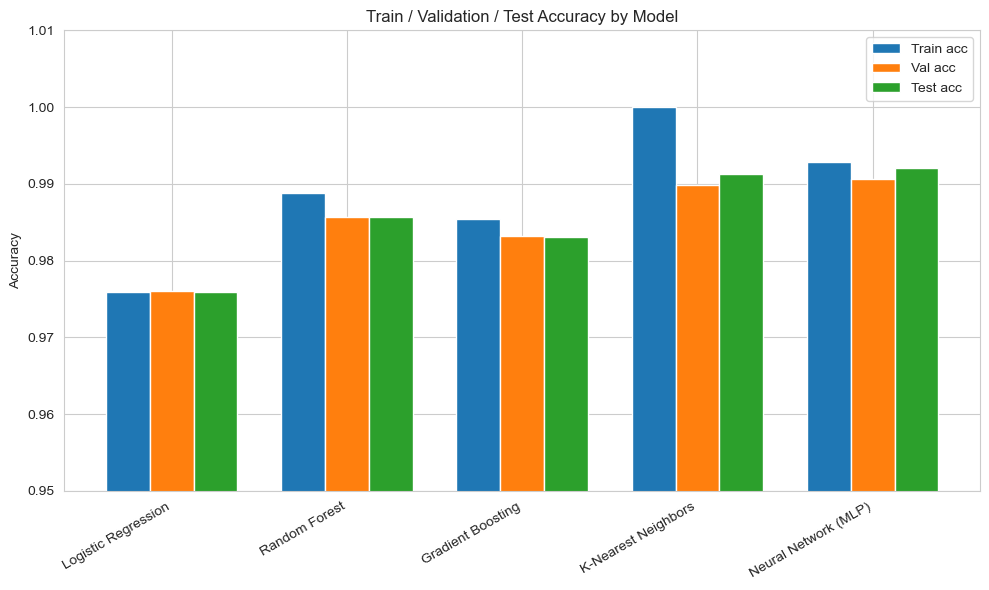

In [114]:
import matplotlib.pyplot as plt
import numpy as np

models = metrics_df.index.tolist()
x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10, 6))

plt.bar(x - width, metrics_df["train_acc"], width, label="Train acc")
plt.bar(x,         metrics_df["val_acc"],   width, label="Val acc")
plt.bar(x + width, metrics_df["test_acc"],  width, label="Test acc")

plt.xticks(x, models, rotation=30, ha="right")
plt.ylabel("Accuracy")
plt.ylim(0.95, 1.01)
plt.title("Train / Validation / Test Accuracy by Model")
plt.legend()
plt.tight_layout()
plt.show()

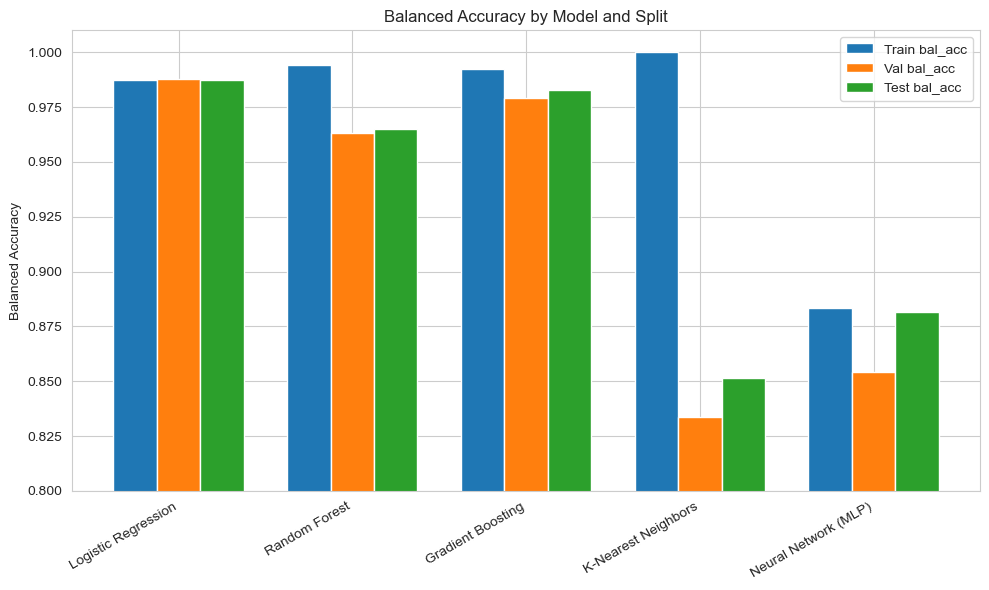

In [115]:
x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10, 6))

plt.bar(x - width, metrics_df["train_bal_acc"], width, label="Train bal_acc")
plt.bar(x,         metrics_df["val_bal_acc"],   width, label="Val bal_acc")
plt.bar(x + width, metrics_df["test_bal_acc"],  width, label="Test bal_acc")

plt.xticks(x, models, rotation=30, ha="right")
plt.ylabel("Balanced Accuracy")
plt.ylim(0.8, 1.01)
plt.title("Balanced Accuracy by Model and Split")
plt.legend()
plt.tight_layout()
plt.show()

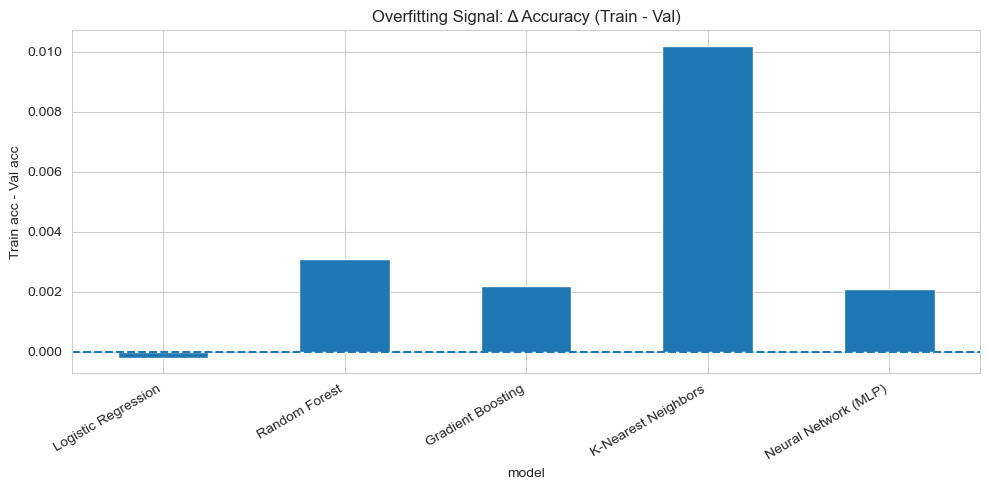

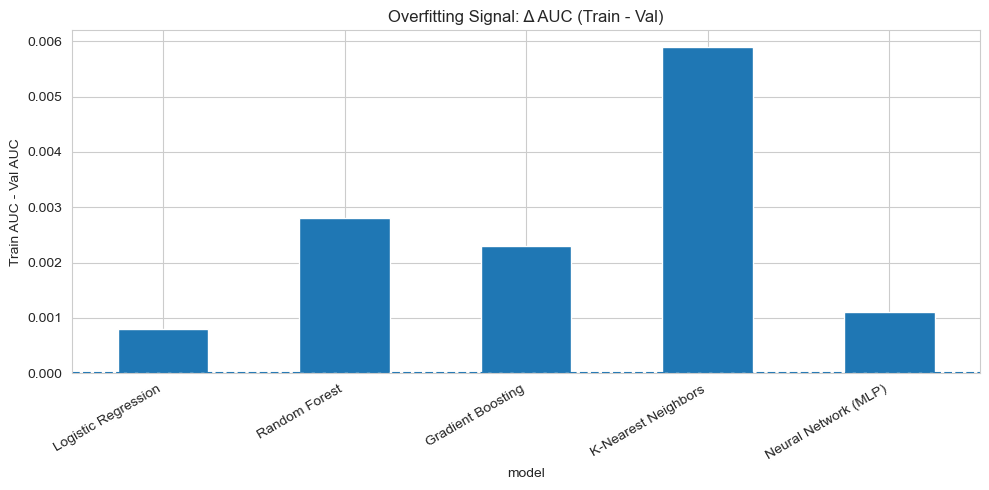

In [116]:
plt.figure(figsize=(10, 5))
metrics_df["delta_acc"].plot(kind="bar")
plt.axhline(0, linestyle="--")
plt.ylabel("Train acc - Val acc")
plt.title("Overfitting Signal: Δ Accuracy (Train - Val)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
metrics_df["delta_auc"].plot(kind="bar")
plt.axhline(0, linestyle="--")
plt.ylabel("Train AUC - Val AUC")
plt.title("Overfitting Signal: Δ AUC (Train - Val)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

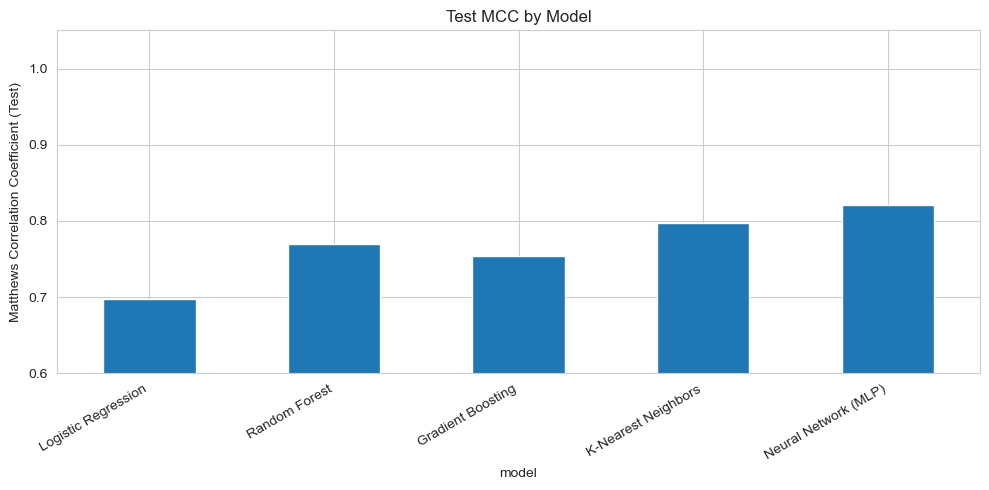

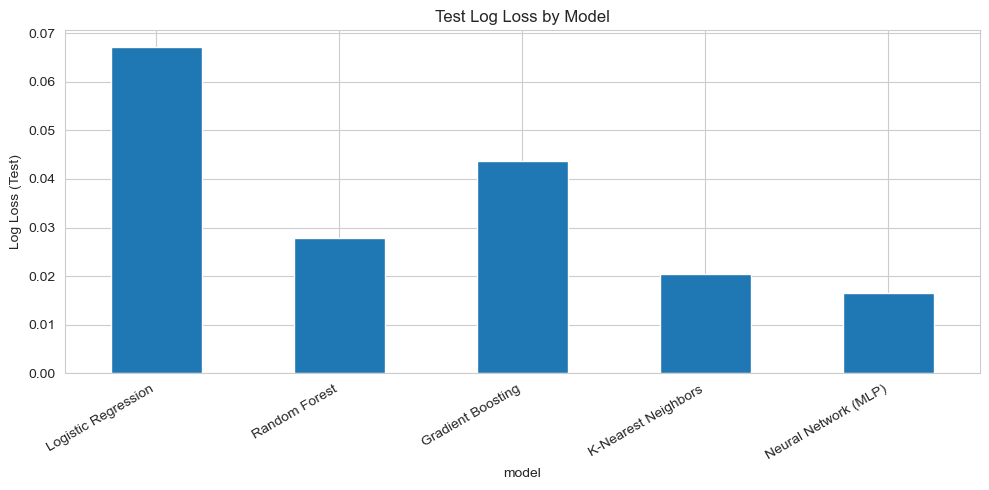

In [117]:
plt.figure(figsize=(10, 5))
metrics_df["test_mcc"].plot(kind="bar")
plt.ylabel("Matthews Correlation Coefficient (Test)")
plt.ylim(0.6, 1.05)
plt.title("Test MCC by Model")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
metrics_df["test_log_loss"].plot(kind="bar")
plt.ylabel("Log Loss (Test)")
plt.title("Test Log Loss by Model")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

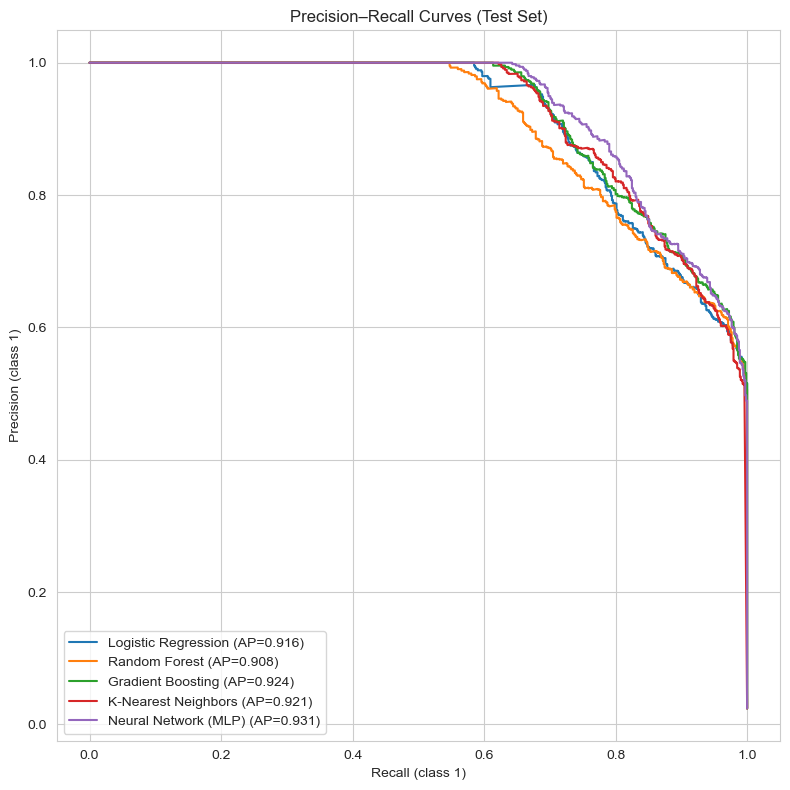

In [120]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 8))

for name, clf in models_dict.items():
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)[:, 1]
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)
    else:
        continue

    precision, recall, _ = precision_recall_curve(y_test, y_score)
    ap = average_precision_score(y_test, y_score)
    plt.plot(recall, precision, lw=1.5, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall (class 1)")
plt.ylabel("Precision (class 1)")
plt.title("Precision–Recall Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()